<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/cifar10_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# **Load the dataset**

In [11]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the desired labels (airplane, automobile, ship, and truck)
classes_name = ['airplane', 'automobile', 'ship', 'truck']
desired_indices = [labels.index(label) for label in classes_name]

# Filter the training dataset to include only images with the desired labels
mask_train = np.isin(y_train, desired_indices).flatten()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Filter the test dataset to include only images with the desired labels
mask_test = np.isin(y_test, desired_indices).flatten()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Print the shapes of the filtered datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (20000, 32, 32, 3)
y_train shape: (20000, 1)
X_test shape: (4000, 32, 32, 3)
y_test shape: (4000, 1)


# **Data visualization**

<ipython-input-12-6a9508f2eb8f>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


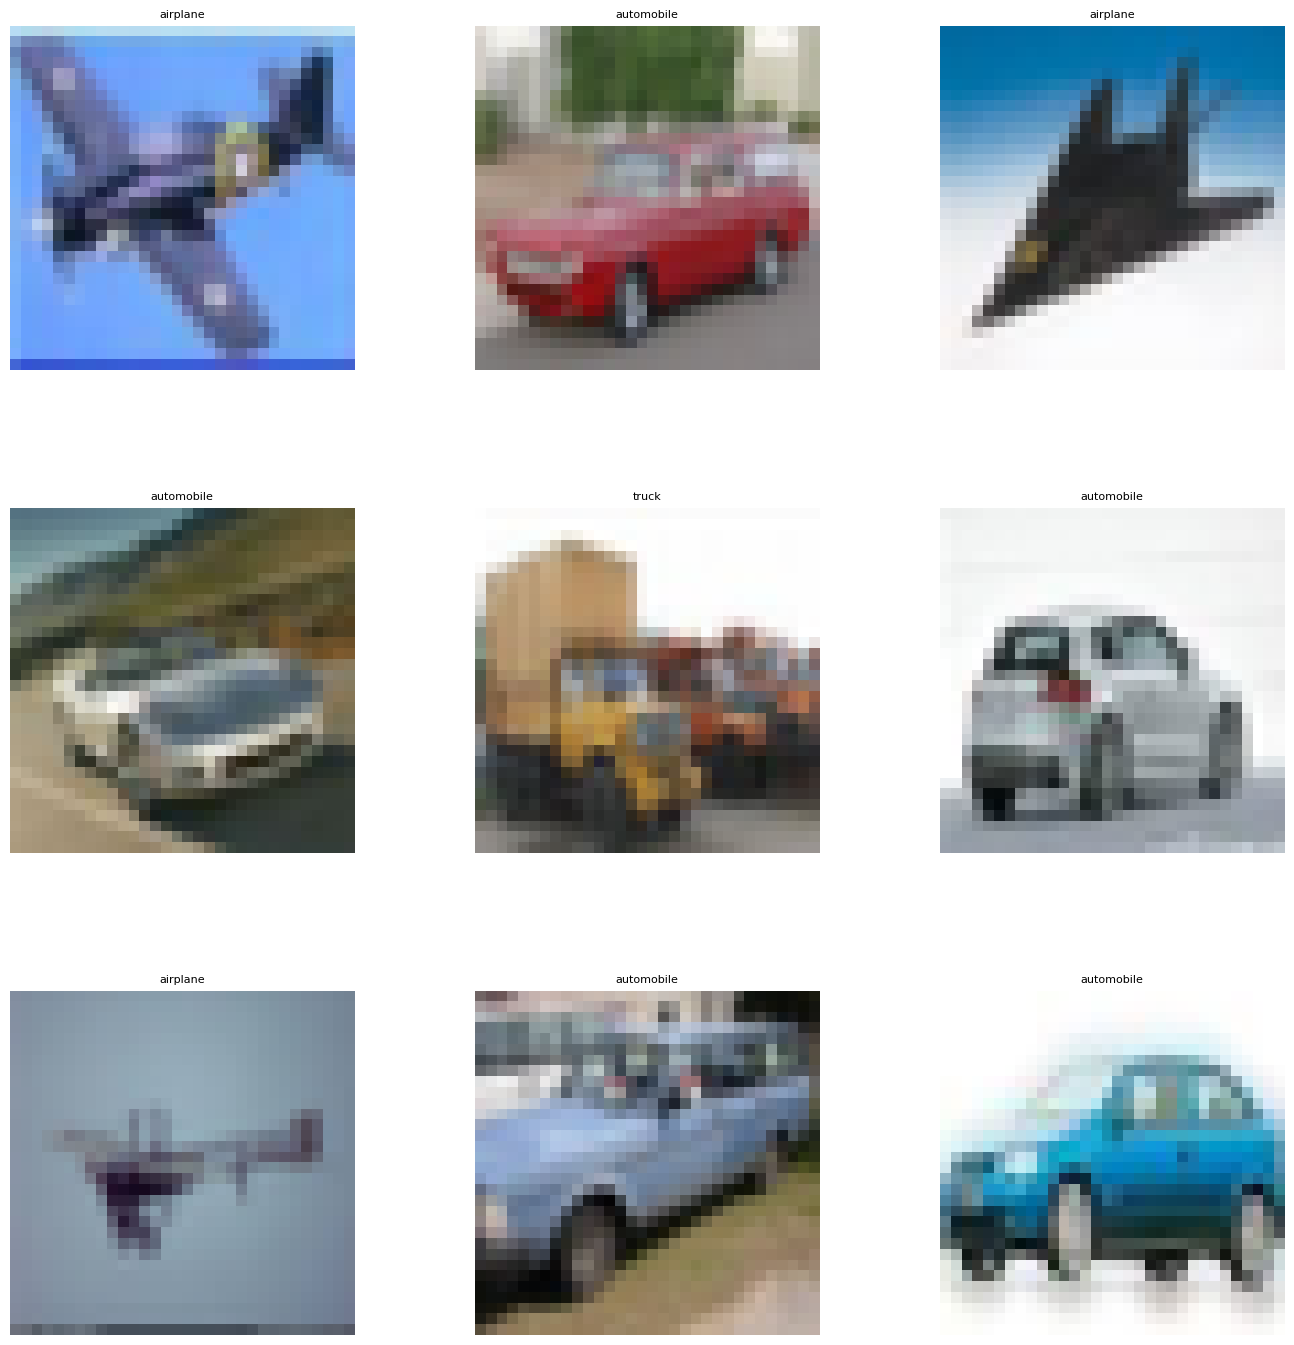

In [12]:
W_grid = 3
L_grid = 3

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()  # Flatten the 10 x 10 matrix into 100 array

n_filtered = len(X_train)  # get the length of the filtered dataset

# Select a random number from 0 to n_filtered
for i in np.arange(0, W_grid * L_grid):  # create evenly spaced variables

    # Select a random number
    index = np.random.randint(0, n_filtered)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index])

    # Get the corresponding label index
    label_index = int(y_train[index])

    # Display the corresponding label name
    axes[i].set_title(labels[label_index], fontsize=8)

    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

Text(0.5, 1.0, 'Class distribution in training set')

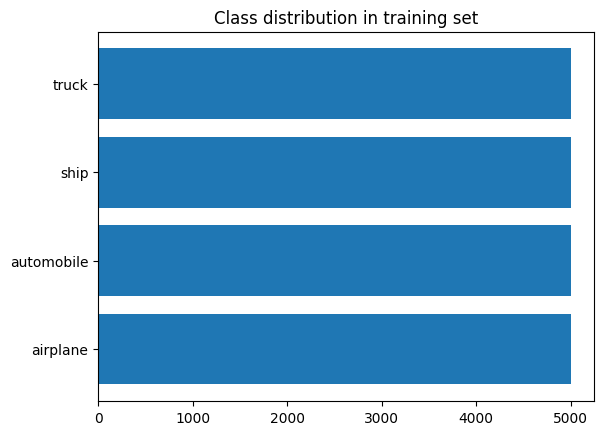

In [13]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

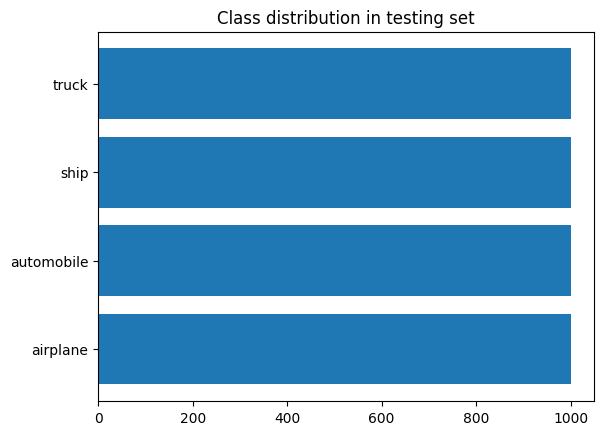

In [14]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

# **Data preprocessing**

In [15]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [23]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# **Model Building**

In [24]:
import time

INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

early_stop = EarlyStopping(monitor='val_loss', patience=2)

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size


start_time = time.time()

r = model.fit(train_generator,
              epochs=20,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

# End time
end_time = time.time()
training_time = end_time - start_time

# Log memory usage for GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
memory_usage = None
if gpu_devices:
    memory_info = tf.config.experimental.get_memory_info('GPU:0')
    memory_usage = memory_info['peak'] / (1024 ** 2)

print(f"Training Time for ResNet: {training_time:.2f} seconds")
if memory_usage:
    print(f"Peak GPU Memory Usage for ResNet: {memory_usage:.2f} MB")

# Additional metrics like accuracy, precision, recall can be obtained from r
final_accuracy = max(r.history['accuracy'])
final_precision = max(r.history['precision'])
final_recall = max(r.history['recall'])

# Print the final results for the DenseNet model
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")

Epoch 1/20
625/625 [==============================] - 27s 40ms/step - loss: 1.0343 - accuracy: 0.5926 - precision: 0.6595 - recall: 0.4848 - val_loss: 0.6586 - val_accuracy: 0.7412 - val_precision: 0.7907 - val_recall: 0.6915
Epoch 2/20
625/625 [==============================] - 25s 40ms/step - loss: 0.6571 - accuracy: 0.7490 - precision: 0.7937 - recall: 0.6925 - val_loss: 1.0437 - val_accuracy: 0.6665 - val_precision: 0.6926 - val_recall: 0.6428
Epoch 3/20
625/625 [==============================] - 25s 40ms/step - loss: 0.5147 - accuracy: 0.8091 - precision: 0.8438 - recall: 0.7703 - val_loss: 0.4314 - val_accuracy: 0.8340 - val_precision: 0.8617 - val_recall: 0.8115
Epoch 4/20
625/625 [==============================] - 25s 41ms/step - loss: 0.4449 - accuracy: 0.8378 - precision: 0.8647 - recall: 0.8069 - val_loss: 0.3645 - val_accuracy: 0.8660 - val_precision: 0.8904 - val_recall: 0.8410
Epoch 5/20
625/625 [==============================] - 26s 41ms/step - loss: 0.4003 - accuracy: 0

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

# **Model Evaluation**

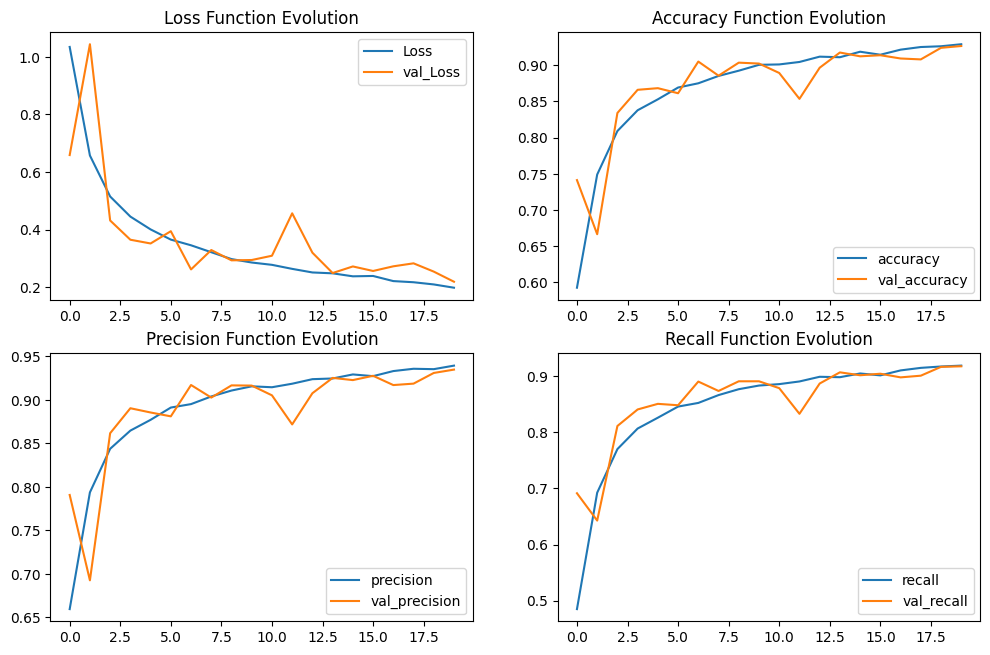

In [26]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

125/125 [==============================] - 1s 10ms/step - loss: 0.2185 - accuracy: 0.9265 - precision: 0.9348 - recall: 0.9180
Test Accuracy : 92.65%
125/125 [==============================] - 1s 10ms/step


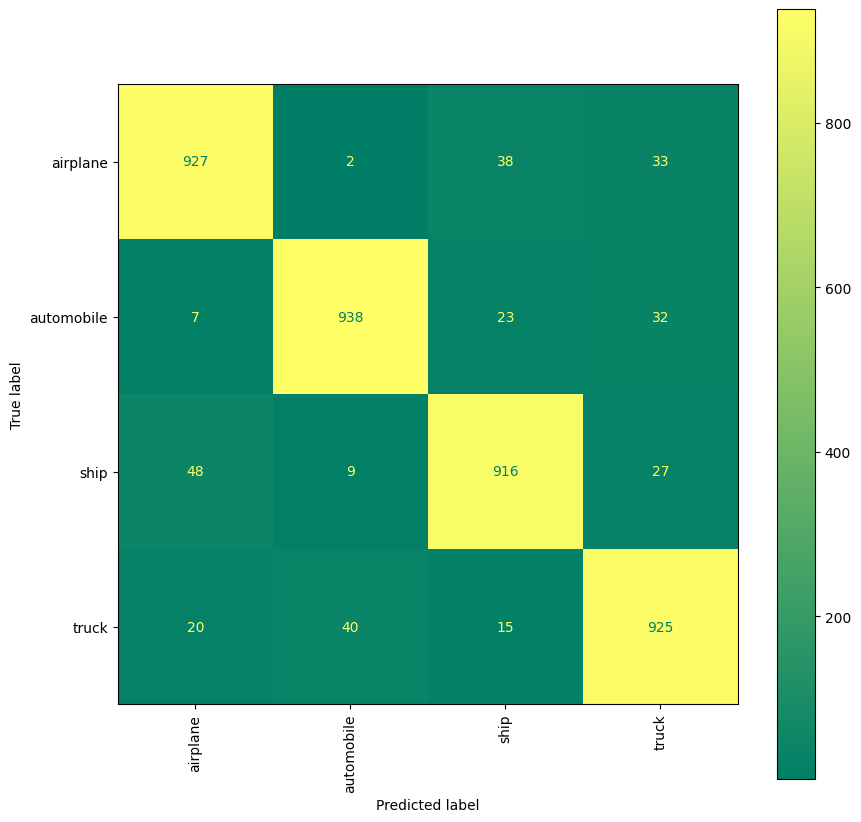

In [27]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_name)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

125/125 [==============================] - 1s 10ms/step - loss: 0.2185 - accuracy: 0.9265 - precision: 0.9348 - recall: 0.9180
Test Accuracy : 92.65%
125/125 [==============================] - 1s 10ms/step


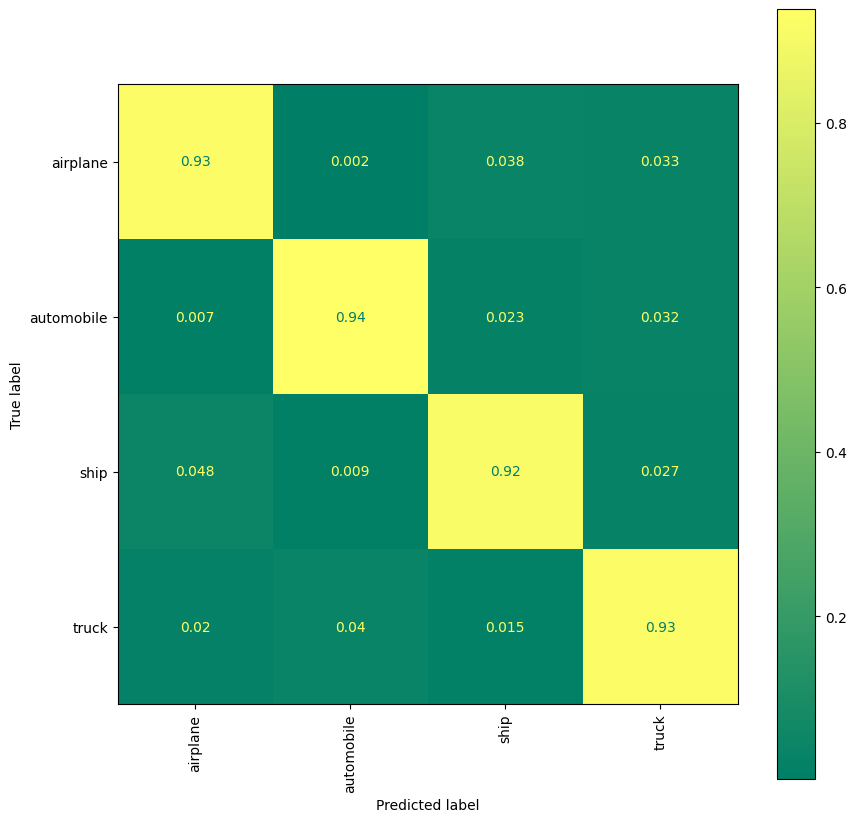

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model and print the test accuracy
evaluation = model.evaluate(X_test, y_cat_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes_name)

# Plot the confusion matrix with values between 0 and 1
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1000
           1       0.95      0.94      0.94      1000
           8       0.92      0.92      0.92      1000
           9       0.91      0.93      0.92      1000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



# **Test on one image**

Image 100 is 1 (automobile)
1/1 [==============================] - 0s 149ms/step
The model predicts that image 100 is 1 - (automobile)


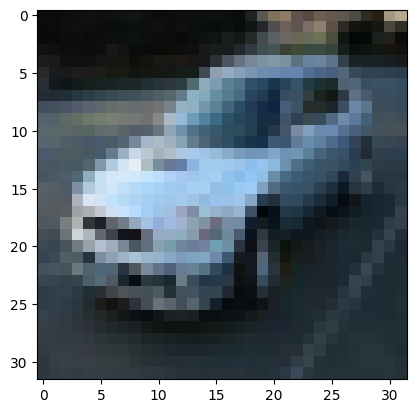

In [29]:
my_image = X_test[100]
plt.imshow(my_image)

true_label = y_test[100][0]
print(f"Image 100 is {true_label} ({labels[true_label]})")

pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predicts that image 100 is {pred_100} - ({labels[pred_100]})")